In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [13]:
df = pd.read_csv(
    "../datasets/breast_cancer.csv", 
    usecols = [
        "radius_mean", "texture_mean", "perimeter_mean", "area_mean", 
        "smoothness_mean", "compactness_mean", "concavity_mean", 
        "concave points_mean", "symmetry_mean", "fractal_dimension_mean", 
        "diagnosis" 
    ]
)

df.rename(columns={
    "radius_mean": "radius",
    "texture_mean": "texture",
    "perimeter_mean": "perimeter",
    "area_mean": "area",
    "smoothness_mean": "smoothness",
    "compactness_mean": "compactness",
    "concavity_mean": "concavity",
    "concave points_mean": "concave_points",
    "symmetry_mean": "symmetry",
    "fractal_dimension_mean": "fractal_dimension",
    "diagnosis": "diagnosis"
}, inplace = True)

df['diagnosis'].replace({
    "M": 1,  
    "B": 0   
}, inplace = True)

df_filtered = df[df['diagnosis'].isin([0, 1])]

num_rows = len(df_filtered)

if num_rows >= 1000:
    df_sample = df_filtered.sample(n = 1000, random_state = 42)
else:
    df_sample = df_filtered

df_sample.head()

/tmp/ipykernel_7709/2501444660.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['diagnosis'].replace({
/tmp/ipykernel_7709/2501444660.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'].replace({


,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [16]:
X = df_sample[[
    "radius", "texture", "perimeter", "area", 
    "smoothness", "compactness", "concavity", 
    "concave_points", "symmetry", "fractal_dimension"
]] 

y = df_sample['diagnosis']

corr_matrix = X.corr()

target_corr = df_sample.corr()['diagnosis']

/tmp/ipykernel_7709/2700000468.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


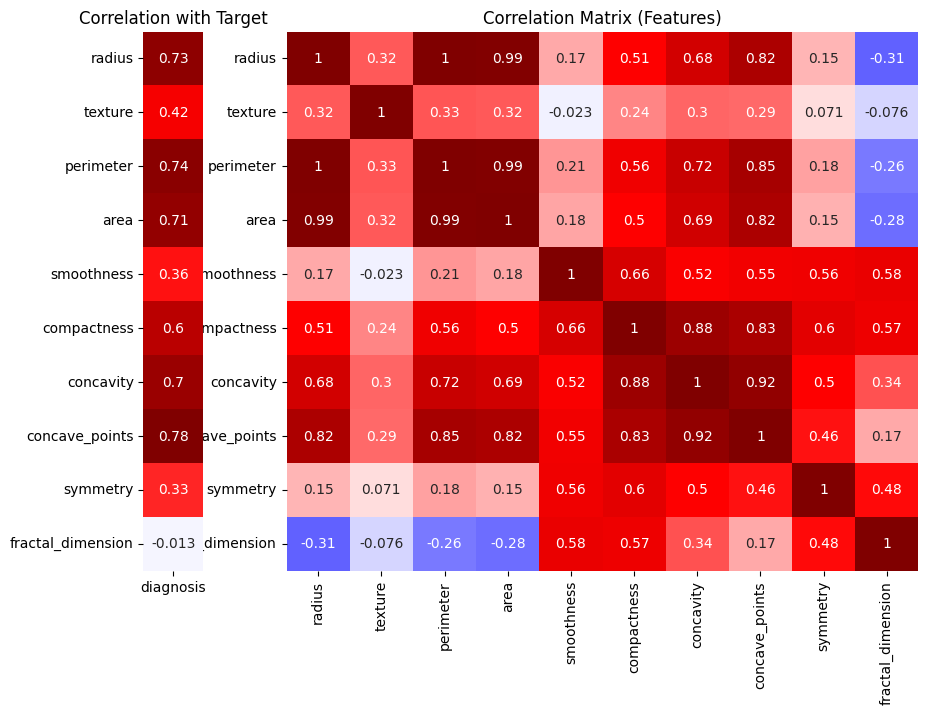

In [17]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(1, 11, (3, 11))  
sns.heatmap(corr_matrix, annot=True, cmap='seismic', cbar=False, ax=ax1, center=0)
ax1.set_title('Correlation Matrix (Features)', fontsize=12)

ax2 = plt.subplot(1, 11, 1)  
sns.heatmap(target_corr.drop('diagnosis').to_frame(), annot=True, cmap='seismic', cbar=False, ax=ax2, center=0)
ax2.set_title('Correlation with Target', fontsize=12)

plt.tight_layout()
plt.show()

## Lasso

In [20]:
# Set feature variable
X = df_sample.drop('diagnosis', axis=1)

# Set target variable
y = df_sample['diagnosis']

print(X.shape) 
print(y.shape)

(569, 10)
(569,)


In [50]:
# Splitting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying LASSO
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.05) 
lasso_model.fit(X_train_scaled, y_train)

y_proba = lasso_model.predict_proba(X_test_scaled)[:, 1]

coef = pd.Series(lasso_model.coef_[0], index=X.columns)
selected_features = coef[coef != 0]
print("Features selected by LASSO:\n")
print(selected_features) 

Features selected by LASSO:

radius            0.701954
texture           0.299339
concave_points    1.857797
dtype: float64


In [51]:
# Model evaluation
y_pred = lasso_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9181286549707602


In [52]:
# Calculate AUROC
auroc = roc_auc_score(y_test, y_proba)
print(f"AUROC do modelo: {auroc}")

AUROC do modelo: 0.9866255144032922


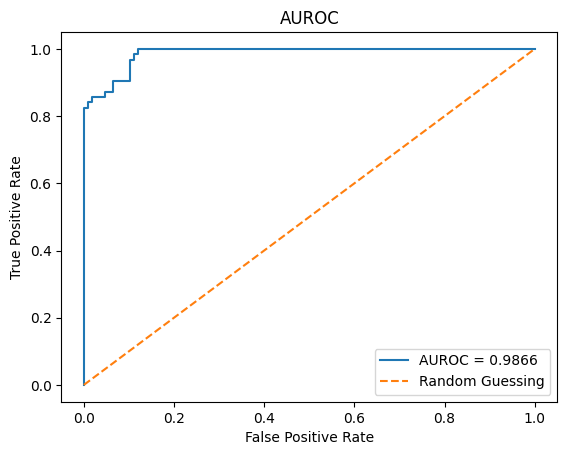

In [53]:
#Plot the graph
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC')
plt.legend()
plt.show()

## RFE